In [1]:
import glob
import os

import numpy as np
import pandas as pd
import scipy.signal

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib inline

import sys
sys.path.append('../../../')
# import bebi103

ip = 200.0/303.0 # Rio 20x air
# ip = 500.0/772.0 # iSIM, xIon 20x air

from scipy.signal import convolve2d
import  seaborn  as sns

##  Analysis - for 2D tracks

In [6]:
files = glob.glob('../../data/processed_tracking/20220920_KDlines_2D/*')

df_2d = pd.DataFrame()
for f in files:
    df_temp = pd.read_csv(f)
#     print(df_temp.head())
    df_2d = df_2d.append(df_temp,  ignore_index = True)

#     if 'GIT' in f:
#         df_temp = pd.read_csv(f)
#         df_2d = df_2d.append(df_temp,  ignore_index = True)

#     if 'Ctrl1' in f:
#         df_temp = pd.read_csv(f)
#         df_2d = df_2d.append(df_temp,  ignore_index = True)
    
# df_2d = df_2d.replace({'sgCtrl1':'HL-60KW_SC575_sgControl1', 'sgGIT2':'HL-60KW_SC575_sgGIT2'})

df_2d.head()

Unnamed: 0  cell  frame           x          y    z            celltype_x  \
0           0   0.0    0.0   17.696717   4.280007  0.0  HL-60KW_SC575_sgGIT2   
1           1   1.0    0.0  385.411319  40.575724  0.0  HL-60KW_SC575_sgGIT2   
2           2   2.0    0.0   80.770207  55.781436  0.0  HL-60KW_SC575_sgGIT2   
3           3   3.0    0.0   96.524781  61.253561  0.0  HL-60KW_SC575_sgGIT2   
4           4   4.0    0.0  165.185838  63.850155  0.0  HL-60KW_SC575_sgGIT2   

   position acqtime aqctime_sec        date            celltype_y  material  \
0         0   30sec       30sec  20220920.0  HL-60KW_SC575_sgGIT2       NaN   
1         0   30sec       30sec  20220920.0  HL-60KW_SC575_sgGIT2       NaN   
2         0   30sec       30sec  20220920.0  HL-60KW_SC575_sgGIT2       NaN   
3         0   30sec       30sec  20220920.0  HL-60KW_SC575_sgGIT2       NaN   
4         0   30sec       30sec  20220920.0  HL-60KW_SC575_sgGIT2       NaN   

   concentration        scope magnification  trial        media  \
0            NaN  Rio_NikonTi        20xAir    6.0  L-15_10%FBS   
1            NaN  Rio_NikonTi        20xAir    6.0  L-15_10%FBS   
2            NaN  Rio_NikonTi        20xAir    6.0  L-15_10%FBS   
3            NaN  Rio_NikonTi        20xAir    6.0  L-15_10%FBS   
4            NaN  Rio_NikonTi        20xAir    6.0  L-15_10%FBS   

                           misc  analysis_date  
0  10ug/ml fibronectin, slide 2     20220922.0  
1  10ug/ml fibronectin, slide 2     20220922.0  
2  10ug/ml fibronectin, slide 2     20220922.0  
3  10ug/ml fibronectin, slide 2     20220922.0  
4  10ug/ml fibronectin, slide 2     20220922.0

## Filter tracks

For 2D, it is clear that some tracks need to be filtered out due to them moving from fluid flow instead of migration.  I'd like to use altair to pick and identify cells

In [10]:
df_2d.columns
df_2d = df_2d[['cell', 'frame', 'x', 'y', 'z', 'celltype_x', 'position',
       'acqtime', 'aqctime_sec', 'date', 'material',
       'concentration', 'scope', 'magnification', 'trial', 'media', 'misc',
       'analysis_date']]
df_2d.columns = ['cell', 'frame', 'x', 'y', 'z', 'celltype', 'position',
       'acqtime', 'aqctime_sec', 'date', 'material',
       'concentration', 'scope', 'magnification', 'trial', 'media', 'misc',
       'analysis_date']

In [27]:
df_2d.celltype.unique()

array(['HL-60KW_SC575_sgGIT2', 'HL-60KW_SC575_sgControl1'], dtype=object)

In [11]:
df_2d.head()

cell  frame           x          y    z              celltype  position  \
0   0.0    0.0   17.696717   4.280007  0.0  HL-60KW_SC575_sgGIT2         0   
1   1.0    0.0  385.411319  40.575724  0.0  HL-60KW_SC575_sgGIT2         0   
2   2.0    0.0   80.770207  55.781436  0.0  HL-60KW_SC575_sgGIT2         0   
3   3.0    0.0   96.524781  61.253561  0.0  HL-60KW_SC575_sgGIT2         0   
4   4.0    0.0  165.185838  63.850155  0.0  HL-60KW_SC575_sgGIT2         0   

  acqtime aqctime_sec        date  material  concentration        scope  \
0   30sec       30sec  20220920.0       NaN            NaN  Rio_NikonTi   
1   30sec       30sec  20220920.0       NaN            NaN  Rio_NikonTi   
2   30sec       30sec  20220920.0       NaN            NaN  Rio_NikonTi   
3   30sec       30sec  20220920.0       NaN            NaN  Rio_NikonTi   
4   30sec       30sec  20220920.0       NaN            NaN  Rio_NikonTi   

  magnification  trial        media                          misc  \
0        20xAir    6.0  L-15_10%FBS  10ug/ml fibronectin, slide 2   
1        20xAir    6.0  L-15_10%FBS  10ug/ml fibronectin, slide 2   
2        20xAir    6.0  L-15_10%FBS  10ug/ml fibronectin, slide 2   
3        20xAir    6.0  L-15_10%FBS  10ug/ml fibronectin, slide 2   
4        20xAir    6.0  L-15_10%FBS  10ug/ml fibronectin, slide 2   

   analysis_date  
0     20220922.0  
1     20220922.0  
2     20220922.0  
3     20220922.0  
4     20220922.0

In [28]:
import altair as alt
import numpy as np
import pandas as pd
alt.data_transformers.enable('default', max_rows=None)

df_2d_ = df_2d[df_2d.celltype == 'HL-60KW_SC575_sgControl1']
df_2d_ = df_2d[df_2d.position == 0]
df_2d_ = df_2d_[df_2d_.trial == 2]


for sg, d in df_2d_.groupby('celltype'):
    print(sg)
    count = 0
    for g, d_ in d.groupby(['position']):
        count += 1
        print(g)
#         if count == 0: 
        print(count)
        print(g)
        d_['y'] = -1.0*d_['y']
        plot_ = alt.Chart(d_).mark_line(
            point=alt.OverlayMarkDef(color="red")
        ).encode(
            x='x',
            y='y',
            color='cell:N',
            tooltip=['celltype', 'cell', 'position', 'frame']
        ).interactive()
        break
            

HL-60KW_SC575_sgControl1
0
1
0
HL-60KW_SC575_sgGIT2
0
1
0


In [29]:
# print(sg, g)
plot_

alt.Chart(...)

## Bayesian inference of persistence

In [30]:

# compute likelihood on parameter grid
def compLike(vp,v):
    return np.exp(-((v[0] - qGrid*vp[0])**2 + (v[1] - qGrid*vp[1])**2)/(2*a2Grid) - np.log(2*np.pi*a2Grid))

# compute new prior
def compNewPrior(oldPrior,like):
    # compute posterior distribution
    post = oldPrior*like
    post /= np.sum(post)

    # use posterior as a starting point to create new prior
    newPrior = post

    # introduce minimal probability
    mask = newPrior < pMin
    newPrior[mask] = pMin

    # apply boxcar filter
    ker = np.ones((2*Rq + 1, 2*Ra+1))/((2*Rq+1)*(2*Ra+1))

    newPrior = convolve2d(newPrior, ker, mode='same', boundary='symm')

    return newPrior

# compute sequence of posterior distributions for a sequence of measured velocities
def compPostSequ(uList):
    # initialize array for posterior distributions
    dist = np.empty((len(uList),gridSize,gridSize))

    # initialize flat prior
    dist[0].fill(1.0/(gridSize**2))

    # forward pass (create forward priors for all time steps)
    for i in np.arange(1,len(uList)):
        dist[i] = compNewPrior(dist[i-1], compLike(uList[i-1], uList[i]))

    # backward pass
    backwardPrior = np.ones((gridSize,gridSize))/(gridSize**2)
    for i in np.arange(1,len(uList))[::-1]:
        # re-compute likelihood
        like = compLike(uList[i-1], uList[i])

        # forward prior * likelihood * backward prior
        dist[i] = dist[i-1]*like*backwardPrior
        dist[i] /= np.sum(dist[i])

        # generate new backward prior for next iteration
        backwardPrior = compNewPrior(backwardPrior, compLike(uList[i-1], uList[i]))

    # drop initial flat prior before return
    return dist[1:]

# compute posterior mean values from a list of posterior distributions
def compPostMean(postSequ):
    qMean = [np.sum(post*qGrid) for post in postSequ]
    aMean = [np.sum(post*aGrid) for post in postSequ]

    return np.array([qMean,aMean])


In [31]:
# parameter boundaries
gridSize = 200
qBound = [-1.5, 1.5]
aBound = [0.0, 0.5]
# aBound = [0.0, 10.0]

# algorithm parameters
# pMin = 1.0*10**(-7)
pMin = 1.0*10**(-5)
Rq   = 2
Ra   = 2

# likelihood function
# parameter grid (excluding boundary values)
qGrid  = (np.array([np.linspace(qBound[0], qBound[1], gridSize+2)[1:-1]]*gridSize)).T
aGrid  = (np.array([np.linspace(aBound[0], aBound[1], gridSize+2)[1:-1]]*gridSize))
a2Grid = (np.array([np.linspace(aBound[0], aBound[1], gridSize+2)[1:-1]]*gridSize))**2

In [32]:
df_groups_plt1 = df_2d.groupby(['celltype'])
###################################################
########## velocities ########
################################################### 
celltype_index = dict(zip(df_2d.celltype.sort_values().unique(), np.arange(0,8).T)) 

    
for i, data in df_groups_plt1:

    # make DataFrame to save Parameter estimates
    df_Bayesian = pd.DataFrame()
    df_Bayesian2 = pd.DataFrame()

    activity_avg = []
    persistence_avg = []
    print(i)

    index = celltype_index[i]
    material = i    
                
    vel = np.array([]) 
    count = 0
    
    df_groups_2_ = data.groupby(['cell', 'trial', 'position', 'date'])
    meanPost1_all_P = []
    meanPost1_all_A = []
    meanPost1_length = []
    
    for j, data_ in df_groups_2_:
        
        data_ = data_[['x','y', 'frame']]
        dx = []
        dy = []
        dz = []
        
        df = data_
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna()

        disp = 0
        series_len = df.frame.max() - df.frame.min()

        if df.empty:
            continue
            
        for t in np.arange(df.frame.min(),df.frame.max()):
 
            dx_ = df[df.frame==t+1].x.values - \
                    df[df.frame==t].x.values

            dx = np.append(dx,dx_)

            dy_ = df[df.frame==t+1].y.values - \
                    df[df.frame==t].y.values
            dy = np.append(dy,dy_)

            
            if (len(dx_) == 0):
                continue
        
        if len(dx)<15:
            continue
    
#         print(j)
        # Now lets begin Bayesian analysis of cell track
        veloSequ1 = np.zeros([len(dx), 2])
        veloSequ1[:,0] = dx/30.0 # um /sec
        veloSequ1[:,1] = dy/30.0 # um /sec
        
        postSequ1 = compPostSequ(veloSequ1)
#         print(postSequ1)
        meanPost1 = compPostMean(postSequ1)
        meanPost1_all_P = np.append(meanPost1_all_P, meanPost1[0])
        meanPost1_all_A = np.append(meanPost1_all_A, meanPost1[1])
        count += 1
        
        # append average persistence and activity values to dataframe
        data_Bayesian = {'cell':j[0], 
                'celltype':i, 
                'trial':j[1],
                'date':j[-1],
                'position':j[-2],
                 'concentration' : '',
                'average_persistence':np.mean(meanPost1[0]), 
                'activity ($\mu$m/sec)':np.mean(meanPost1[1]),
                'speed ($\mu$m/sec)': np.mean(np.sqrt(veloSequ1[:,0]**2 + \
                                    veloSequ1[:,1]**2)),
                         'material':material}
        df_Bayesian = df_Bayesian.append(data_Bayesian, ignore_index=True)
        
        # append all inference values to dataframe
        for t in np.arange(len(veloSequ1)-1):#df.frame.unique():#np.arange(df.frame.min(), df.frame.max()):# + len(dx)):
            data_Bayesian2 = {'cell':j[0], 
                              'celltype':i, 
                              'frame':t, 
                'Vx ($\mu$m/sec)':veloSequ1[:,0][int(t)],
                'Vy ($\mu$m/sec)':veloSequ1[:,1][int(t)],
                'speed ($\mu$m/sec)': np.sqrt(veloSequ1[:,0][int(t)]**2 + \
                                    veloSequ1[:,1][int(t)]**2 ),
                'trial':j[1],
                'date':j[-1],
                'position':j[-2],
                 'concentration' : '',
                'material':material, 
                'persistence':meanPost1[0][int(t)], 
                'activity ($\mu$m/sec)':meanPost1[1][int(t)]}
            df_Bayesian2 = df_Bayesian2.append(data_Bayesian2, ignore_index=True)

            #     fname_ = '_'.join([str(j[-1]), i, str(j[1]), str(g[-2]), '.csv']) 
    fname_ = '_'.join([i, '_all.csv']) 
    df_Bayesian.to_csv('../../data/processed_tracking_bayesian/20220920_2D_filtered_avg'+fname_)
    df_Bayesian2.to_csv('../../data/processed_tracking_bayesian/20220920_2D_filtered_'+fname_)

HL-60KW_SC575_sgControl1
HL-60KW_SC575_sgGIT2


In [33]:
files_bay_2d = glob.glob('../../data/processed_tracking_bayesian/20220920_2D_filtered_avg*all*')
files_bay_2d    

df_Bayesian = pd.DataFrame()
for f in files_bay_2d:
    df_temp = pd.read_csv(f)
    df_Bayesian = df_Bayesian.append(df_temp, ignore_index = True)

HL-60KW_SC575_sgControl1 214
HL-60KW_SC575_sgControl1
0.2073506573905933
0.3917784924916942
HL-60KW_SC575_sgGIT2 238
HL-60KW_SC575_sgGIT2
0.24964923868684374
0.43177207995845723


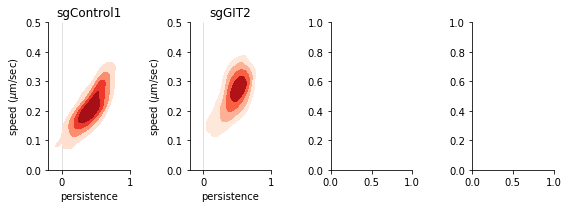

In [37]:
f, axes = plt.subplots(1, 4, figsize = (8,3))
axes = axes.ravel()
sns.despine(right=True)

ind_dict  = dict(zip(['HL-60KW_SC575_sgControl1', 'HL-60KW_SC575_sgGIT2'], np.arange(4)))
# i = 0
for c, d in df_Bayesian.groupby('celltype'):
    i = ind_dict[c]
    print(c, len(d.cell.unique()))
    sns.kdeplot(data = d, x = 'average_persistence',
                y = 'speed ($\mu$m/sec)', 
                ax=axes[i],
                shade=True,
                thresh=0.2,
               cmap="Reds",
                n_levels=5)
    print(c)
    print(d['speed ($\mu$m/sec)'].mean())
    print(d['average_persistence'].mean())
    axes[i].set_ylim(0,0.5)
    axes[i].set_xlim(-0.2,1.0)
    axes[i].set_xlabel('persistence')
    axes[i].vlines(x = 0,ymin  = 0, ymax=0.5, lw = 0.5, alpha  = 0.25, zorder = 0, color = 'k')
    axes[i].set_title(c.split('_')[-1])
    
plt.tight_layout()

In [131]:
df_Bayesian.celltype.unique()

array(['HL-60KW_SC575_sgITGB2', 'HL-60KW_SC575_sgLAMTOR1',
       'HL-60KW_SC575_sgFLCN', 'HL-60KW_SC575_sgControl1'], dtype=object)

(20220920.0, 1.0, 0.0) 63
(20220920.0, 1.0, 1.0) 66
(20220920.0, 1.0, 2.0) 68
(20220920.0, 1.0, 3.0) 74
(20220920.0, 1.0, 4.0) 71
(20220920.0, 2.0, 0.0) 140
(20220920.0, 2.0, 1.0) 131
(20220920.0, 2.0, 2.0) 148
(20220920.0, 2.0, 3.0) 111
(20220920.0, 2.0, 4.0) 131


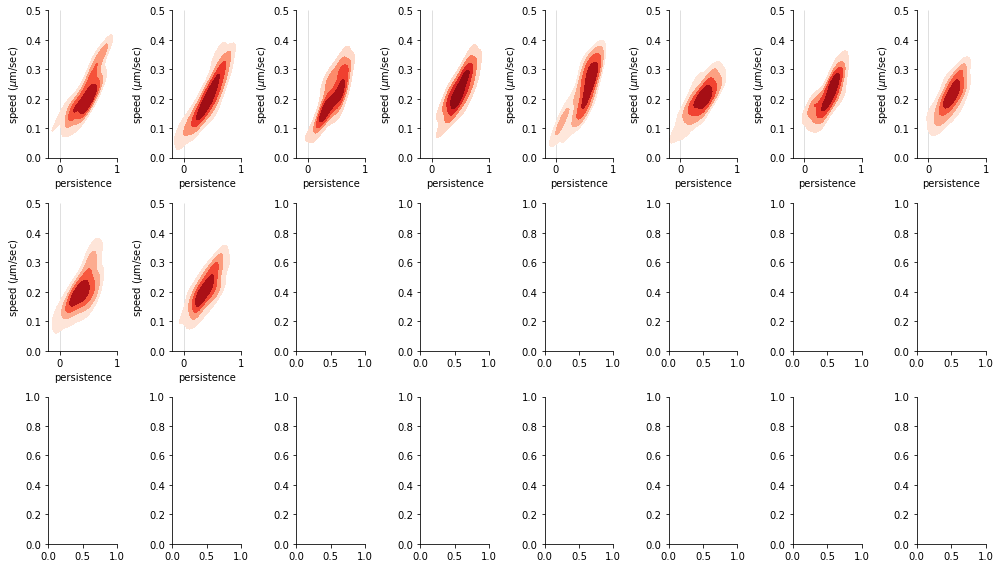

In [35]:
f, axes = plt.subplots(3, 8, figsize = (14,8))
axes = axes.ravel()
sns.despine(right=True)

i = 0
for c, d in df_Bayesian[df_Bayesian.celltype  == 'HL-60KW_SC575_sgControl1'].groupby(['date', 'trial', 'position']):
    print(c, len(d.cell.unique()))
    sns.kdeplot(data = d, x = 'average_persistence',
                y = 'speed ($\mu$m/sec)', 
                ax=axes[i],
                shade=True,
                thresh=0.2,
               cmap="Reds",
                n_levels=5)

    axes[i].set_ylim(0,0.5)
    axes[i].set_xlim(-0.2,1.0)
    axes[i].set_xlabel('persistence')
    axes[i].vlines(x = 0,ymin  = 0, ymax=0.5, lw = 0.5, alpha  = 0.25, zorder = 0, color = 'k')
    i += 1
    
plt.tight_layout()

(20220920.0, 1.0, 0.0) 140
(20220920.0, 1.0, 1.0) 138
(20220920.0, 1.0, 2.0) 132
(20220920.0, 1.0, 3.0) 131
(20220920.0, 1.0, 4.0) 119
(20220920.0, 2.0, 0.0) 139
(20220920.0, 2.0, 1.0) 144
(20220920.0, 2.0, 2.0) 125
(20220920.0, 2.0, 3.0) 140
(20220920.0, 2.0, 4.0) 136
(20220920.0, 4.0, 0.0) 62
(20220920.0, 4.0, 1.0) 58
(20220920.0, 4.0, 2.0) 63
(20220920.0, 4.0, 3.0) 107
(20220920.0, 4.0, 4.0) 52
(20220920.0, 5.0, 0.0) 56
(20220920.0, 5.0, 1.0) 63


IndexError: index 16 is out of bounds for axis 0 with size 16

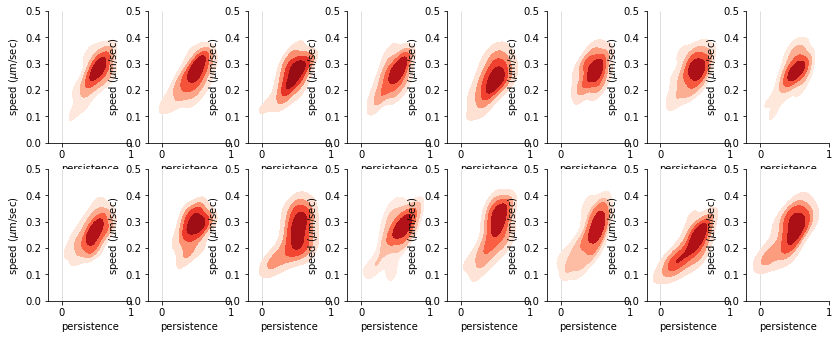

In [36]:
f, axes = plt.subplots(2, 8, figsize = (14,8*(2/3)))
axes = axes.ravel()
sns.despine(right=True)

i = 0
for c, d in df_Bayesian[df_Bayesian.celltype  == 'HL-60KW_SC575_sgGIT2'].groupby(['date', 'trial', 'position']):
    print(c, len(d.cell.unique()))
    sns.kdeplot(data = d, x = 'average_persistence',
                y = 'speed ($\mu$m/sec)', 
                ax=axes[i],
                shade=True,
                thresh=0.2,
               cmap="Reds",
                n_levels=5)

    axes[i].set_ylim(0,0.5)
    axes[i].set_xlim(-0.2,1.0)
    axes[i].set_xlabel('persistence')
    axes[i].vlines(x = 0,ymin  = 0, ymax=0.5, lw = 0.5, alpha  = 0.25, zorder = 0, color = 'k')
    i += 1
    
plt.tight_layout()